## A tutorial on Emprical V-information

* source: https://github.com/mmalekzadeh/v-information

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

#### 1. Introduction
In this notebook, we first build a synthetic `dataset`, then we try to understand how we can define a `predictive family` and calculate the `emprical v-information` according to that.


According to the original [paper](https://openreview.net/forum?id=r1eBeyHFDH), the definiton of `emprical v-information` is:

![](figures/def_4.png)

#### 2. Dataset
Let us assume that:
- A dataset $\mathcal{D}$ includes pairs of $(X_n \in \mathbb{R}^M,y_n \in \{0,1,2,\dots,K-1\})$.
- $N$ is the number of data samples, $M$ is the number of features per each sample, and $K$ is the number possible classes.
- Each $x_{(n,m)} \in \mathbb{R}$ shows the value of the $m$-th feature of the $n$-th sample.

Let also assume that we have the knoweldge that:
- Each $x_n$ belongs to class $y_n=k \in \{0,1,2,\dots,K-1\})$
- Each $x_{(n,m)}$ comes from a normal distribution of the form $\mathcal{N}(\mu_k, \sigma^2_k)$

Note that we do not know what is the true mean $\mu_k$ or the true $\sigma_k$ for each class. We just know that they each data sample is generated from a normal distribution.

##### Hidden Variables
Let us assume we have `4` different classes of data and each class is parametrized by the following $\mu_k$, $\sigma^2_k$:

In [2]:
mus = [2, 5, -1, 3] 
sigmas = [1.75, .5, .75, 1.25]

In [3]:
def get_dataset(mus, sigmas, features, samples):
    X = np.array([[np.random.normal(mu, sigma, features) for _ in range(samples)] 
                  for mu, sigma in zip(mus, sigmas)]).reshape(samples*len(mus),features)
    Y = np.array([[c]*samples for c in range(len(mus))]).reshape(samples*len(mus))
    return X, Y.astype(int)

In [4]:
features = 8
samples_per_class = 12

X, Y = get_dataset(mus, sigmas, features, samples_per_class)
print("Dataset:", X.shape, Y.shape)

Dataset: (48, 8) (48,)


In [5]:
print("-- Sample Data:",X[0], "\n-- Class:", Y[0])

-- Sample Data: [ 2.84704497  0.17990754  1.92709281  0.04284044  3.4665739  -0.71279684
  1.71998555  2.43617934] 
-- Class: 0


For visualization, we plot each sample in the dataset:

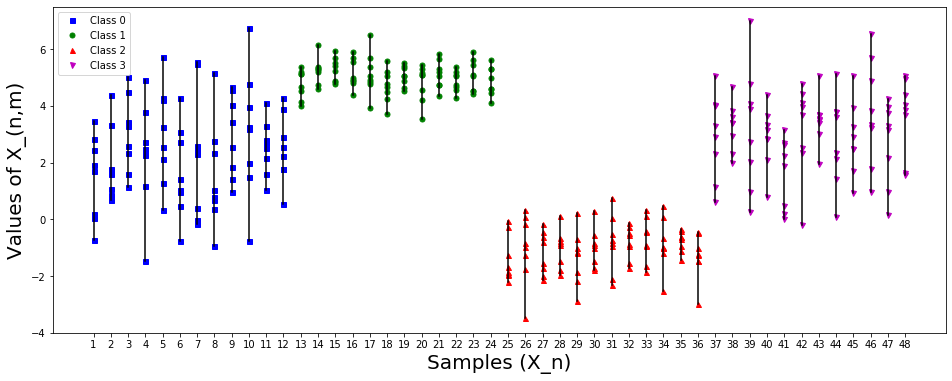

In [6]:
plt.figure(figsize=(16,6))
cms = ["sb","og","^r","vm"]
for k in range(len(mus)):
    for m in range(features):
        if m == 0:
            plt.plot(range(k*samples_per_class+1, (k+1)*samples_per_class+1),
                 X[k*samples_per_class:(k+1)*samples_per_class,m], cms[k], 
                 markersize=5, label = "Class "+str(k))
        else:
            plt.plot(range(k*samples_per_class+1, (k+1)*samples_per_class+1),
                 X[k*samples_per_class:(k+1)*samples_per_class,m], cms[k], 
                 markersize=5)
plt.plot((range(1,len(X)+1),range(1,len(X)+1)),(X.min(1), X.max(1)),c='black')
plt.xlabel("Samples (X_n)",size =20)
plt.ylabel("Values of X_(n,m)",size =20)
plt.xticks(range(1,len(X)+1))
plt.legend()

#### 3. Emperical Estimation
We have a dataset at hand and we know that the distribution for each class is normal distribution.

Using this knowlege, we calculate emperical mean and variance for each class.

In [7]:
emperical_mus = np.array([X[Y==i].mean() for i in range(len(mus))])
emperical_sigmas = np.array([X[Y==i].std() for i in range(len(mus))])
print("True vs. emperical MEAN for each class", *zip(mus, emperical_mus.round(2)))
print("True vs. emperical STD for each class", *zip(sigmas,emperical_sigmas.round(2)))

True vs. emperical MEAN for each class (2, 2.35) (5, 5.01) (-1, -1.02) (3, 3.03)
True vs. emperical STD for each class (1.75, 1.65) (0.5, 0.53) (0.75, 0.8) (1.25, 1.47)


#### 4. Calcuating V-Information

##### 4.1 First Term: V-Entropy
Here we assume, having no input (observation) we calculate the probability of each class based on its frequency in the dataset. 

And this seems to be the best we can do! Meaning that this give us the `infimum` value.

In [8]:
def get_best_estimation_of_probability(Y):
    _u, _l = np.unique(Y, return_inverse=True)    
    return np.histogram(_l, bins=np.arange(_u.size+1))[0][_l] / _l.size

In [9]:
get_best_estimation_of_probability(Y)

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25])

This `get_best_estimation_of_probability` is our $f[\emptyset](y_i)$.

Having this function, we can calculate **emperical V-Entropy**.

In [10]:
def get_v_entropy(Y):
    f_null_Y = get_best_estimation_of_probability(Y)
    log_value = -np.log(f_null_Y)
    inf_value = log_value.sum()/len(Y)
    return inf_value

In [11]:
v_entropy = get_v_entropy(Y)
print("First Term | V-Entropy: {:.4f}".format(v_entropy))

First Term | V-Entropy: 1.3863


##### 4.2 Second Term: Conditional V-Entropy

Here, we need a function for cacluating $f[X_i](y_i)$.

We should find the best function that gives us the `infimum` value.

It seems the best we can do for each sample $(X_i,y_i)$ is to build a normal distribution based on the emperical mean and variance that we have:

`norm(loc=emperical_mus[Y[i]], scale=emperical_sigmas[Y[i]])`

Then using this, calculate the PDF for each $X_i$:

`norm(loc=emperical_mus[Y[i]], scale=emperical_sigmas[Y[i]]).pdf(X[i])).mean()`

In [12]:
def get_best_estimation_of_conditional_probability(X,Y):
    ## We assume having a sample data point, we can use its mean and std 
    ## as the emperical parameters to calcualte probability of each label.
    return np.array([(norm(loc=emperical_mus[Y[i]], scale=emperical_sigmas[Y[i]]).pdf(X[i])).mean()
                     for i in range(len(X))])

In [13]:
def get_cond_v_entropy(X, Y):
    f_X_Y = get_best_estimation_of_conditional_probability(X,Y)
    log_value = -np.log(f_X_Y)
    inf_value = log_value.sum()/len(Y)
    return inf_value

In [14]:
cond_v_entropy = get_cond_v_entropy(X, Y)
print("Second Term | Conditional V-Entropy: {:.4f}".format(cond_v_entropy))

Second Term | Conditional V-Entropy: 1.2761


So, without further ado:

In [15]:
print("Emperical V_information (X --> Y; dataset): {:.4f}".format(v_entropy - cond_v_entropy))

Emperical V_information (X --> Y; dataset): 0.1101
